<a href="https://colab.research.google.com/github/tjmj-uva/DLIP_project/blob/main/EfficientNet_replication_v2S.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# IMPORTANT: RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES,
# THEN FEEL FREE TO DELETE THIS CELL.
# NOTE: THIS NOTEBOOK ENVIRONMENT DIFFERS FROM KAGGLE'S PYTHON
# ENVIRONMENT SO THERE MAY BE MISSING LIBRARIES USED BY YOUR
# NOTEBOOK.
import kagglehub
jbeltranleon_nih_chest_xrays_224_gray_path = kagglehub.dataset_download('jbeltranleon/nih-chest-xrays-224-gray')
vinu210110b_data_entry_2017_v2020_path = kagglehub.dataset_download('vinu210110b/data-entry-2017-v2020')

print('Data source import complete.')


100%|██████████| 2.43G/2.43G [01:58<00:00, 22.0MB/s]

Extracting files...


100%|██████████| 954k/954k [00:00<00:00, 1.02MB/s]

Extracting files...
Data source import complete.


<a href="https://colab.research.google.com/github/tjmj-uva/DLIP_project/blob/main/EfficientNet%20-%20replication.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [15]:
# IMPORTANT: RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES,
# THEN FEEL FREE TO DELETE THIS CELL.
# NOTE: THIS NOTEBOOK ENVIRONMENT DIFFERS FROM KAGGLE'S PYTHON
# ENVIRONMENT SO THERE MAY BE MISSING LIBRARIES USED BY YOUR
# NOTEBOOK.
import kagglehub
jbeltranleon_nih_chest_xrays_224_gray_path = kagglehub.dataset_download('jbeltranleon/nih-chest-xrays-224-gray')
vinu210110b_data_entry_2017_v2020_path = kagglehub.dataset_download('vinu210110b/data-entry-2017-v2020')

print('Data source import complete.')

import google.protobuf.message_factory as mf
if not hasattr(mf.MessageFactory, "GetPrototype"):
    mf.MessageFactory.GetPrototype = lambda *args, **kwargs: None


Using Colab cache for faster access to the 'nih-chest-xrays-224-gray' dataset.
Using Colab cache for faster access to the 'data-entry-2017-v2020' dataset.
Data source import complete.


In [16]:
import os
import numpy as np
import pandas as pd
import tqdm
import matplotlib
import matplotlib.pyplot as plt
import sklearn
import tensorflow as tf
from sklearn.metrics import roc_curve, auc, roc_auc_score
from sklearn.model_selection import train_test_split
from glob import glob
from itertools import chain
from contextlib import redirect_stdout
import shutil
import warnings
import json

# TensorFlow 2.x / Keras imports
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Input, Dense
from tensorflow.keras.applications import (
    EfficientNetV2B0,
    EfficientNetV2B1,
    EfficientNetV2B2,
    EfficientNetV2B3,
    EfficientNetV2S,
    EfficientNetV2M,
    EfficientNetV2L)

from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import ModelCheckpoint, TensorBoard, ReduceLROnPlateau, Callback
from tensorflow.keras.optimizers import Adam
import tensorflow.keras.backend as kb
from tensorflow.keras import mixed_precision
mixed_precision.set_global_policy('mixed_float16')

print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

print(tf.__version__)
print(tf.test.is_built_with_cuda())  # Should be True

Num GPUs Available:  1
2.19.0
True


In [17]:
# Kaggle automatically mounts datasets at /kaggle/input/
inpath = jbeltranleon_nih_chest_xrays_224_gray_path + "/"
print("Dataset contents:")
print(os.listdir(inpath))

# Load data
data = pd.read_csv(os.path.join(vinu210110b_data_entry_2017_v2020_path, 'Data_Entry_2017_v2020.csv'))
print(f"shape : {data.shape}")

data.head()

data = data[data['Patient Age']<100]

print(f" shape : {data.shape}")

data = data[['Image Index', 'Finding Labels']]

print(f" shape: {data.shape}")

# Map image paths
all_image_paths = {os.path.basename(x): x for x in
                   glob(os.path.join(inpath, '**/*.png'), recursive=True)}
print('Imágenes encontradas:', len(all_image_paths))

data['Path'] = data['Image Index'].map(all_image_paths.get)

# Remove rows where image path is missing
data = data.dropna(subset=['Path'])
print(f"After filtering missing images: {data.shape}")

data.sample(5, random_state=3)


# Extract unique labels
all_labels = np.unique(list(chain(*data['Finding Labels'].map(lambda x: x.split('|')).tolist())))

all_labels

all_labels = np.delete(all_labels, np.where(all_labels == 'No Finding'))
print(f'Tipo actual: {type(all_labels)}')

all_labels = [x for x in all_labels]
print(f'Tipo final: {type(all_labels)}')

print(f'Enfermedades: ({len(all_labels)}): {all_labels}')

# Create binary columns for each disease
for c_label in all_labels:
    if len(c_label)>1: # leave out empty labels
        # Add a column for each disease
        data[c_label] = data['Finding Labels'].map(lambda finding: 1 if c_label in finding else 0)

print(f"shape: {data.shape}")
data.head()

label_counts = data['Finding Labels'].value_counts()
label_counts

# Filter out rare disease combinations
data = data.groupby('Finding Labels').filter(lambda x : len(x)>11)

label_counts = data['Finding Labels'].value_counts()
print(label_counts.shape)
label_counts

Dataset contents:
['images']
shape : (112120, 11)
 shape : (112120, 11)
 shape: (112120, 2)
Imágenes encontradas: 112120
After filtering missing images: (112120, 3)
Tipo actual: <class 'numpy.ndarray'>
Tipo final: <class 'list'>
Enfermedades: (14): [np.str_('Atelectasis'), np.str_('Cardiomegaly'), np.str_('Consolidation'), np.str_('Edema'), np.str_('Effusion'), np.str_('Emphysema'), np.str_('Fibrosis'), np.str_('Hernia'), np.str_('Infiltration'), np.str_('Mass'), np.str_('Nodule'), np.str_('Pleural_Thickening'), np.str_('Pneumonia'), np.str_('Pneumothorax')]
shape: (112120, 17)
(198,)


,count
Finding Labels,
No Finding,60361
Infiltration,9547
Atelectasis,4215
Effusion,3955
Nodule,2705
...,...
Atelectasis|Consolidation|Effusion|Infiltration|Mass|Nodule,13
Effusion|Emphysema|Infiltration|Pneumothorax,12
Atelectasis|Nodule|Pleural_Thickening,12


In [18]:
# Split data into train/validation/test
train_and_valid_df, test_df = train_test_split(data,
                                               test_size = 0.20,
                                               random_state = 2018,
                                              )

train_df, valid_df = train_test_split(train_and_valid_df,
                                      test_size=0.20,
                                      random_state=2018,
                                     )

print(f'Entrenamiento {train_df.shape[0]} Validación {valid_df.shape[0]} Prueba: {test_df.shape[0]}')

# Create data generator
base_generator = ImageDataGenerator(rescale=1./255)

IMG_SIZE = (224, 224)
def flow_from_dataframe(image_generator, dataframe, batch_size):

    df_gen = image_generator.flow_from_dataframe(dataframe,
                                                 x_col='Path',
                                                 y_col=all_labels,
                                                 target_size=IMG_SIZE,
                                                 classes=all_labels,
                                                 color_mode='rgb',
                                                 class_mode='raw',
                                                 shuffle=False,
                                                 batch_size=batch_size)

    return df_gen

train_gen = flow_from_dataframe(image_generator=base_generator,
                                dataframe= train_df,
                                batch_size = 32)

valid_gen = flow_from_dataframe(image_generator=base_generator,
                                dataframe=valid_df,
                                batch_size = 32)

test_gen = flow_from_dataframe(image_generator=base_generator,
                               dataframe=test_df,
                               batch_size = 32)

train_x, train_y = next(train_gen)
print(f"Dimensiones de la imagen: {train_x[1].shape}")
print(f"Vector de enfermedades: {train_y[1]}")

# Build model
input_shape=(224, 224, 3)
img_input = Input(shape=input_shape)

Entrenamiento 70660 Validación 17666 Prueba: 22082


/usr/local/lib/python3.12/dist-packages/keras/src/legacy/preprocessing/image.py:854: UserWarning: `classes` will be ignored given the class_mode="raw"
  warnings.warn(


Found 70660 validated image filenames.


/usr/local/lib/python3.12/dist-packages/keras/src/legacy/preprocessing/image.py:854: UserWarning: `classes` will be ignored given the class_mode="raw"
  warnings.warn(


Found 17666 validated image filenames.


/usr/local/lib/python3.12/dist-packages/keras/src/legacy/preprocessing/image.py:854: UserWarning: `classes` will be ignored given the class_mode="raw"
  warnings.warn(


Found 22082 validated image filenames.
Dimensiones de la imagen: (224, 224, 3)
Vector de enfermedades: [0 0 1 0 0 0 0 0 0 0 0 0 0 0]


In [20]:
base_model = EfficientNetV2S(include_top=False, input_tensor=img_input, input_shape=input_shape,
                         pooling="avg", weights='imagenet')

x = base_model.output
predictions = Dense(len(all_labels), activation="sigmoid", name="predictions")(x)
model = Model(inputs=img_input, outputs=predictions)

# Save model summary
with open('model_summary.txt', 'w') as f:
    model.summary(print_fn=lambda x: f.write(x + '\n'))

# Setup callbacks
model_train = model
output_weights_name='weights.weights.h5'
checkpoint = ModelCheckpoint(
             output_weights_name,
             save_weights_only=True,
             save_best_only=True,
             verbose=1,
            )

In [21]:
#Custom AUROC callback
class MultipleClassAUROC(Callback):
    """
    Monitor mean AUROC and update model
    """
    def __init__(self, generator, class_names, weights_path, stats=None):
        super(Callback, self).__init__()
        self.generator = generator
        self.class_names = class_names
        self.weights_path = weights_path
        self.best_weights_path = os.path.join(
            os.path.split(weights_path)[0],
            f"best_{os.path.split(weights_path)[1]}",
        )
        self.best_auroc_log_path = os.path.join(
            os.path.split(weights_path)[0],
            "best_auroc.log",
        )
        self.stats_output_path = os.path.join(
            os.path.split(weights_path)[0],
            ".training_stats.json"
        )
        # for resuming previous training
        if stats:
            self.stats = stats
        else:
            self.stats = {"best_mean_auroc": 0}

        # aurocs log
        self.aurocs = {}
        for c in self.class_names:
            self.aurocs[c] = []

    def on_epoch_end(self, epoch, logs={}):
        """
        Calcula el promedio de las Curvas ROC y guarda el mejor grupo de pesos
        de acuerdo a esta metrica
        """
        print("\n*********************************")
        self.stats["lr"] = float(kb.get_value(self.model.optimizer.learning_rate))
        print(f"Learning Rate actual: {self.stats['lr']}")

        """
        y_hat shape: (#ejemplos, len(etiquetas))
        y: [(#ejemplos, 1), (#ejemplos, 1) ... (#ejemplos, 1)]
        """
        y_hat = self.model.predict(self.generator, steps=len(self.generator), verbose=0)
        y_hat = y_hat[:len(self.generator.labels)]
        y = self.generator.labels

        print(f"*** epoch#{epoch + 1} Curvas ROC Fase Entrenamiento ***")
        current_auroc = []
        for i in range(len(self.class_names)):
            try:
                score = roc_auc_score(y[:, i], y_hat[:, i])
            except ValueError:
                score = 0
            self.aurocs[self.class_names[i]].append(score)
            current_auroc.append(score)
            print(f"{i+1}. {self.class_names[i]}: {score}")
        print("*********************************")

        mean_auroc = np.mean(current_auroc)
        print(f"Promedio Curvas ROC: {mean_auroc}")
        if mean_auroc > self.stats["best_mean_auroc"]:
            print(f"Actualización del resultado de las Curvas de ROC de: {self.stats['best_mean_auroc']} a {mean_auroc}")

            # 1. copy best model
            shutil.copy(self.weights_path, self.best_weights_path)

            # 2. update log file
            print(f"Actualización del archivo de logs: {self.best_auroc_log_path}")
            with open(self.best_auroc_log_path, "a") as f:
                f.write(f"(epoch#{epoch + 1}) auroc: {mean_auroc}, lr: {self.stats['lr']}\n")

            # 3. write stats output, this is used for resuming the training
            with open(self.stats_output_path, 'w') as f:
                json.dump(self.stats, f)

            print(f"Actualización del grupo de pesos: {self.weights_path} -> {self.best_weights_path}")
            self.stats["best_mean_auroc"] = mean_auroc
            print("*********************************")
        return

training_stats = {}
auroc = MultipleClassAUROC(
    generator=valid_gen,
    class_names=all_labels,
    weights_path=output_weights_name,
    stats=training_stats
)

# Compile model
initial_learning_rate=1e-3
optimizer = Adam(learning_rate=initial_learning_rate)  # Changed from 'lr' to 'learning_rate'
model_train.compile(optimizer=optimizer, loss="binary_crossentropy")

# Setup all callbacks
logs_base_dir = '/kaggle/working/'
patience_reduce_lr=2
min_lr=1e-8
callbacks = [
            checkpoint,
            TensorBoard(log_dir=os.path.join(logs_base_dir, "logs")),
            ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=patience_reduce_lr,
                              verbose=1, mode="min", min_lr=min_lr),
            auroc,
        ]

/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/25
2208/2208 ━━━━━━━━━━━━━━━━━━━━ 0s 188ms/step - loss: 0.1729
Epoch 1: val_loss improved from inf to 0.17877, saving model to weights.weights.h5

*********************************
Learning Rate actual: 0.0010000000474974513
*** epoch#1 Curvas ROC Fase Entrenamiento ***
1. Atelectasis: 0.6225145833337102
2. Cardiomegaly: 0.5679349040748092
3. Consolidation: 0.6680016059419853
4. Edema: 0.6502573389617254
5. Effusion: 0.6788488083438371
6. Emphysema: 0.5209211164562175
7. Fibrosis: 0.5550729507127864
8. Hernia: 0.45087869649671225
9. Infiltration: 0.5838463105119043
10. Mass: 0.4965979557264037
11. Nodule: 0.4919551609037783
12. Pleural_Thickening: 0.5333859723187347
13. Pneumonia: 0.5849454562997783
14. Pneumothorax: 0.6123194283422886
*********************************
Promedio Curvas ROC: 0.5726771634589051
Actualización del resultado de las Curvas de ROC de: 0 a 0.5726771634589051
Actualización del archivo de logs: best_auroc.log
Actualización del grupo de pesos: weights.weig

/usr/local/lib/python3.12/dist-packages/keras/src/trainers/epoch_iterator.py:116: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()



Epoch 2: val_loss improved from 0.17877 to 0.17859, saving model to weights.weights.h5

*********************************
Learning Rate actual: 0.0010000000474974513
*** epoch#2 Curvas ROC Fase Entrenamiento ***
1. Atelectasis: 0.6044219876893455
2. Cardiomegaly: 0.5557240302117736
3. Consolidation: 0.629871865186906
4. Edema: 0.5447610200353037
5. Effusion: 0.6533654493441947
6. Emphysema: 0.5255693321411642
7. Fibrosis: 0.5437763430208347
8. Hernia: 0.4500086620172842
9. Infiltration: 0.5727068366116406
10. Mass: 0.49481489389313377
11. Nodule: 0.4857896102640557
12. Pleural_Thickening: 0.5246896584021393
13. Pneumonia: 0.5776566613433152
14. Pneumothorax: 0.6085540028295724
*********************************
Promedio Curvas ROC: 0.5551221680707618
2208/2208 ━━━━━━━━━━━━━━━━━━━━ 327s 73ms/step - loss: 0.2110 - val_loss: 0.1786 - learning_rate: 0.0010
Epoch 3/25
2208/2208 ━━━━━━━━━━━━━━━━━━━━ 0s 188ms/step - loss: 0.1538
Epoch 3: val_loss did not improve from 0.17859

****************

/usr/local/lib/python3.12/dist-packages/keras/src/trainers/epoch_iterator.py:116: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()



Epoch 4: val_loss did not improve from 0.17859

Epoch 4: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.

*********************************
Learning Rate actual: 0.00010000000474974513
*** epoch#4 Curvas ROC Fase Entrenamiento ***
1. Atelectasis: 0.6304210683789984
2. Cardiomegaly: 0.517190960222527
3. Consolidation: 0.7029278419437635
4. Edema: 0.6516616032261755
5. Effusion: 0.7326080677693135
6. Emphysema: 0.5194396574955329
7. Fibrosis: 0.6055044557037635
8. Hernia: 0.6383055867711832
9. Infiltration: 0.579861157648557
10. Mass: 0.5432746154893868
11. Nodule: 0.5290551911789773
12. Pleural_Thickening: 0.5633373024918923
13. Pneumonia: 0.5087551122843852
14. Pneumothorax: 0.5115306860265371
*********************************
Promedio Curvas ROC: 0.5881338076164996
2208/2208 ━━━━━━━━━━━━━━━━━━━━ 107s 49ms/step - loss: 0.2122 - val_loss: 0.1807 - learning_rate: 0.0010
Epoch 5/25
2208/2208 ━━━━━━━━━━━━━━━━━━━━ 0s 180ms/step - loss: 0.1446
Epoch 5: val_loss improved 

/usr/local/lib/python3.12/dist-packages/keras/src/trainers/epoch_iterator.py:116: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()



Epoch 6: val_loss did not improve from 0.15438

*********************************
Learning Rate actual: 0.00010000000474974513
*** epoch#6 Curvas ROC Fase Entrenamiento ***
1. Atelectasis: 0.7764640632323436
2. Cardiomegaly: 0.8641605236741481
3. Consolidation: 0.7953108196756571
4. Edema: 0.8604082490671728
5. Effusion: 0.864602372028553
6. Emphysema: 0.8207437248742764
7. Fibrosis: 0.7456725935834501
8. Hernia: 0.7551883950431797
9. Infiltration: 0.679746643646528
10. Mass: 0.7535896888432151
11. Nodule: 0.6775263572320835
12. Pleural_Thickening: 0.7460763524695443
13. Pneumonia: 0.6836557909703931
14. Pneumothorax: 0.8277130716805178
*********************************
Promedio Curvas ROC: 0.7750613318586473
2208/2208 ━━━━━━━━━━━━━━━━━━━━ 182s 82ms/step - loss: 0.2065 - val_loss: 0.1594 - learning_rate: 1.0000e-04
Epoch 7/25
2208/2208 ━━━━━━━━━━━━━━━━━━━━ 0s 222ms/step - loss: 0.1406
Epoch 7: val_loss improved from 0.15438 to 0.14967, saving model to weights.weights.h5

*************

/usr/local/lib/python3.12/dist-packages/keras/src/trainers/epoch_iterator.py:116: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()



Epoch 8: val_loss did not improve from 0.14967

*********************************
Learning Rate actual: 0.00010000000474974513
*** epoch#8 Curvas ROC Fase Entrenamiento ***
1. Atelectasis: 0.7738001797014755
2. Cardiomegaly: 0.8668988487955392
3. Consolidation: 0.7995211299665906
4. Edema: 0.8758985320530854
5. Effusion: 0.8628043573314389
6. Emphysema: 0.836288938393695
7. Fibrosis: 0.7571720320196528
8. Hernia: 0.787907057321091
9. Infiltration: 0.6890497939677194
10. Mass: 0.7732100549430314
11. Nodule: 0.7042006202599597
12. Pleural_Thickening: 0.7478528321404049
13. Pneumonia: 0.6931799970194519
14. Pneumothorax: 0.8446315269259556
*********************************
Promedio Curvas ROC: 0.7866011357742207
2208/2208 ━━━━━━━━━━━━━━━━━━━━ 154s 70ms/step - loss: 0.1923 - val_loss: 0.1518 - learning_rate: 1.0000e-04
Epoch 9/25
2208/2208 ━━━━━━━━━━━━━━━━━━━━ 0s 192ms/step - loss: 0.1375
Epoch 9: val_loss did not improve from 0.14967

Epoch 9: ReduceLROnPlateau reducing learning rate to 

/usr/local/lib/python3.12/dist-packages/keras/src/trainers/epoch_iterator.py:116: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()



Epoch 10: val_loss did not improve from 0.14967

*********************************
Learning Rate actual: 1.0000000656873453e-05
*** epoch#10 Curvas ROC Fase Entrenamiento ***
1. Atelectasis: 0.7541274266889795
2. Cardiomegaly: 0.8527806619617219
3. Consolidation: 0.7877143645775082
4. Edema: 0.868666609733553
5. Effusion: 0.8583078379906678
6. Emphysema: 0.8125071689070509
7. Fibrosis: 0.7391929203000055
8. Hernia: 0.7733456696812532
9. Infiltration: 0.6802876526138216
10. Mass: 0.7355963063832472
11. Nodule: 0.6923054564049855
12. Pleural_Thickening: 0.7346331237186035
13. Pneumonia: 0.6694430042867684
14. Pneumothorax: 0.835423676310244
*********************************
Promedio Curvas ROC: 0.7710237056827435
2208/2208 ━━━━━━━━━━━━━━━━━━━━ 102s 46ms/step - loss: 0.1654 - val_loss: 0.1610 - learning_rate: 1.0000e-05
Epoch 11/25
2208/2208 ━━━━━━━━━━━━━━━━━━━━ 0s 180ms/step - loss: 0.1345
Epoch 11: val_loss improved from 0.14967 to 0.14272, saving model to weights.weights.h5

*********

/usr/local/lib/python3.12/dist-packages/keras/src/trainers/epoch_iterator.py:116: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()



Epoch 12: val_loss did not improve from 0.14272

*********************************
Learning Rate actual: 1.0000000656873453e-05
*** epoch#12 Curvas ROC Fase Entrenamiento ***
1. Atelectasis: 0.7995712236686416
2. Cardiomegaly: 0.8979251116849679
3. Consolidation: 0.8084563330752353
4. Edema: 0.8911392818390065
5. Effusion: 0.8770537267865225
6. Emphysema: 0.8674077819436133
7. Fibrosis: 0.7767284386843843
8. Hernia: 0.777196817896801
9. Infiltration: 0.699298890072352
10. Mass: 0.8262712700380725
11. Nodule: 0.7206011916725393
12. Pleural_Thickening: 0.7758327140849115
13. Pneumonia: 0.7042736169612354
14. Pneumothorax: 0.85901407607163
*********************************
Promedio Curvas ROC: 0.805769319605708
2208/2208 ━━━━━━━━━━━━━━━━━━━━ 145s 66ms/step - loss: 0.1472 - val_loss: 0.1428 - learning_rate: 1.0000e-05
Epoch 13/25
2208/2208 ━━━━━━━━━━━━━━━━━━━━ 0s 183ms/step - loss: 0.1331
Epoch 13: val_loss did not improve from 0.14272

Epoch 13: ReduceLROnPlateau reducing learning rate t

/usr/local/lib/python3.12/dist-packages/keras/src/trainers/epoch_iterator.py:116: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()



Epoch 14: val_loss did not improve from 0.14272

*********************************
Learning Rate actual: 1.0000001111620804e-06
*** epoch#14 Curvas ROC Fase Entrenamiento ***
1. Atelectasis: 0.7992757853256578
2. Cardiomegaly: 0.8950832592598268
3. Consolidation: 0.8073278720551756
4. Edema: 0.8875592580971253
5. Effusion: 0.8771773834726067
6. Emphysema: 0.8648884725356579
7. Fibrosis: 0.7814992333707709
8. Hernia: 0.7824775822393385
9. Infiltration: 0.698226864099374
10. Mass: 0.8240051038153812
11. Nodule: 0.7206916992527876
12. Pleural_Thickening: 0.773358245599778
13. Pneumonia: 0.6989069781504675
14. Pneumothorax: 0.8577238719687899
*********************************
Promedio Curvas ROC: 0.8048715435173387
2208/2208 ━━━━━━━━━━━━━━━━━━━━ 99s 45ms/step - loss: 0.1342 - val_loss: 0.1431 - learning_rate: 1.0000e-06
Epoch 15/25
2208/2208 ━━━━━━━━━━━━━━━━━━━━ 0s 176ms/step - loss: 0.1325
Epoch 15: val_loss did not improve from 0.14272

Epoch 15: ReduceLROnPlateau reducing learning rate

/usr/local/lib/python3.12/dist-packages/keras/src/trainers/epoch_iterator.py:116: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()



Epoch 16: val_loss did not improve from 0.14272

*********************************
Learning Rate actual: 1.000000082740371e-07
*** epoch#16 Curvas ROC Fase Entrenamiento ***
1. Atelectasis: 0.7979466203043853
2. Cardiomegaly: 0.8967694691994698
3. Consolidation: 0.8070030093488766
4. Edema: 0.8909973676807459
5. Effusion: 0.8764745038025032
6. Emphysema: 0.8668625995182495
7. Fibrosis: 0.7787919753164319
8. Hernia: 0.777318699378941
9. Infiltration: 0.6985679682417416
10. Mass: 0.8272595825872855
11. Nodule: 0.7225822773055581
12. Pleural_Thickening: 0.775680237791394
13. Pneumonia: 0.7040350409362754
14. Pneumothorax: 0.8579885841389259
*********************************
Promedio Curvas ROC: 0.8055912811107703
2208/2208 ━━━━━━━━━━━━━━━━━━━━ 96s 43ms/step - loss: 0.1493 - val_loss: 0.1430 - learning_rate: 1.0000e-07
Epoch 17/25
2208/2208 ━━━━━━━━━━━━━━━━━━━━ 0s 185ms/step - loss: 0.1326
Epoch 17: val_loss did not improve from 0.14272

Epoch 17: ReduceLROnPlateau reducing learning rate 

/usr/local/lib/python3.12/dist-packages/keras/src/trainers/epoch_iterator.py:116: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()



Epoch 18: val_loss did not improve from 0.14272

*********************************
Learning Rate actual: 1.000000082740371e-08
*** epoch#18 Curvas ROC Fase Entrenamiento ***
1. Atelectasis: 0.7994537321160039
2. Cardiomegaly: 0.8936258949484422
3. Consolidation: 0.8084467440243186
4. Edema: 0.887654994605523
5. Effusion: 0.877041449272389
6. Emphysema: 0.8653281079198629
7. Fibrosis: 0.779650358180954
8. Hernia: 0.7818827392824784
9. Infiltration: 0.6989560914507181
10. Mass: 0.8241296521677625
11. Nodule: 0.7199975957930194
12. Pleural_Thickening: 0.7736645755697718
13. Pneumonia: 0.7002036157154852
14. Pneumothorax: 0.857585209435557
*********************************
Promedio Curvas ROC: 0.8048300543201633
2208/2208 ━━━━━━━━━━━━━━━━━━━━ 108s 49ms/step - loss: 0.1355 - val_loss: 0.1432 - learning_rate: 1.0000e-08
Epoch 19/25
2208/2208 ━━━━━━━━━━━━━━━━━━━━ 0s 214ms/step - loss: 0.1327
Epoch 19: val_loss did not improve from 0.14272

Epoch 19: ReduceLROnPlateau reducing learning rate t

/usr/local/lib/python3.12/dist-packages/keras/src/trainers/epoch_iterator.py:116: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()



Epoch 20: val_loss did not improve from 0.14272

*********************************
Learning Rate actual: 9.99999993922529e-09
*** epoch#20 Curvas ROC Fase Entrenamiento ***
1. Atelectasis: 0.7992478912572718
2. Cardiomegaly: 0.8936685989634817
3. Consolidation: 0.8084894914756027
4. Edema: 0.8876296838434643
5. Effusion: 0.8770216866419364
6. Emphysema: 0.8651884437909318
7. Fibrosis: 0.7795072067354003
8. Hernia: 0.7811683144940845
9. Infiltration: 0.6989375396357832
10. Mass: 0.8241574188875658
11. Nodule: 0.719831559223632
12. Pleural_Thickening: 0.7735953620761018
13. Pneumonia: 0.699975283259464
14. Pneumothorax: 0.857477642847992
*********************************
Promedio Curvas ROC: 0.8047068659380506
2208/2208 ━━━━━━━━━━━━━━━━━━━━ 109s 49ms/step - loss: 0.1489 - val_loss: 0.1432 - learning_rate: 1.0000e-08
Epoch 21/25
2208/2208 ━━━━━━━━━━━━━━━━━━━━ 0s 188ms/step - loss: 0.1327
Epoch 21: val_loss did not improve from 0.14272

*********************************
Learning Rate actu

/usr/local/lib/python3.12/dist-packages/keras/src/trainers/epoch_iterator.py:116: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()



Epoch 22: val_loss did not improve from 0.14272

*********************************
Learning Rate actual: 9.99999993922529e-09
*** epoch#22 Curvas ROC Fase Entrenamiento ***
1. Atelectasis: 0.7994995167379786
2. Cardiomegaly: 0.8934521255264967
3. Consolidation: 0.8085741350138369
4. Edema: 0.8882010115030651
5. Effusion: 0.876906364560747
6. Emphysema: 0.8657259390750003
7. Fibrosis: 0.7803254966789916
8. Hernia: 0.7804331928502329
9. Infiltration: 0.6991208932245206
10. Mass: 0.8238594746770438
11. Nodule: 0.7198182661215435
12. Pleural_Thickening: 0.7734384092879687
13. Pneumonia: 0.7005342186420398
14. Pneumothorax: 0.8575637119833225
*********************************
Promedio Curvas ROC: 0.8048180539916278
2208/2208 ━━━━━━━━━━━━━━━━━━━━ 135s 61ms/step - loss: 0.1515 - val_loss: 0.1431 - learning_rate: 1.0000e-08
Epoch 23/25
2208/2208 ━━━━━━━━━━━━━━━━━━━━ 0s 189ms/step - loss: 0.1328
Epoch 23: val_loss did not improve from 0.14272

*********************************
Learning Rate ac

/usr/local/lib/python3.12/dist-packages/keras/src/trainers/epoch_iterator.py:116: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()



Epoch 24: val_loss did not improve from 0.14272

*********************************
Learning Rate actual: 9.99999993922529e-09
*** epoch#24 Curvas ROC Fase Entrenamiento ***
1. Atelectasis: 0.7993897855973627
2. Cardiomegaly: 0.8933307184108423
3. Consolidation: 0.8084143473709868
4. Edema: 0.8879047210174384
5. Effusion: 0.8768887016096045
6. Emphysema: 0.8653204207785675
7. Fibrosis: 0.7799963403707584
8. Hernia: 0.7801863636851443
9. Infiltration: 0.6991184444286779
10. Mass: 0.8238009088193533
11. Nodule: 0.720069658399078
12. Pleural_Thickening: 0.7733743609803936
13. Pneumonia: 0.7002680510684869
14. Pneumothorax: 0.8576123787248202
*********************************
Promedio Curvas ROC: 0.804691085804394
2208/2208 ━━━━━━━━━━━━━━━━━━━━ 108s 49ms/step - loss: 0.1426 - val_loss: 0.1433 - learning_rate: 1.0000e-08
Epoch 25/25
2208/2208 ━━━━━━━━━━━━━━━━━━━━ 0s 191ms/step - loss: 0.1327
Epoch 25: val_loss did not improve from 0.14272

*********************************
Learning Rate act

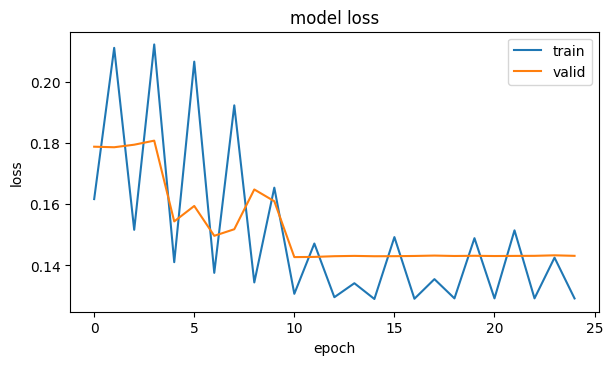

/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


691/691 ━━━━━━━━━━━━━━━━━━━━ 149s 215ms/step
Vector de enfermedades: [0 0 0 0 0 0 0 0 0 0 0 0 0 0]
Vector de enfermedades producto de la predicción: [0.0602   0.01456  0.005817 0.003122 0.01816  0.002434 0.03088  0.00752
 0.10266  0.006695 0.051    0.02538  0.00971  0.001415]
ROC AUC: 0.806637

Training and evaluation complete!
Output files saved to /kaggle/working/


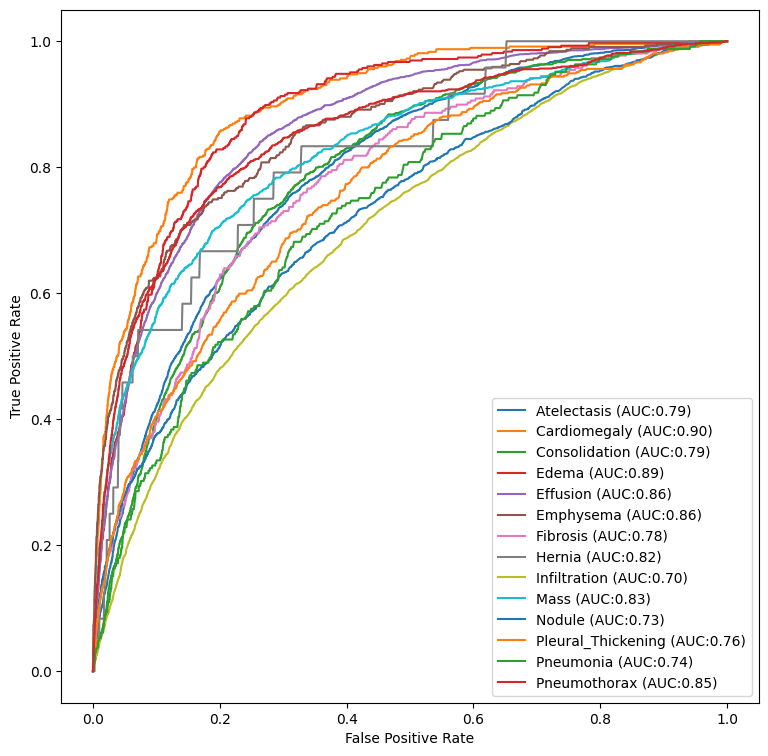

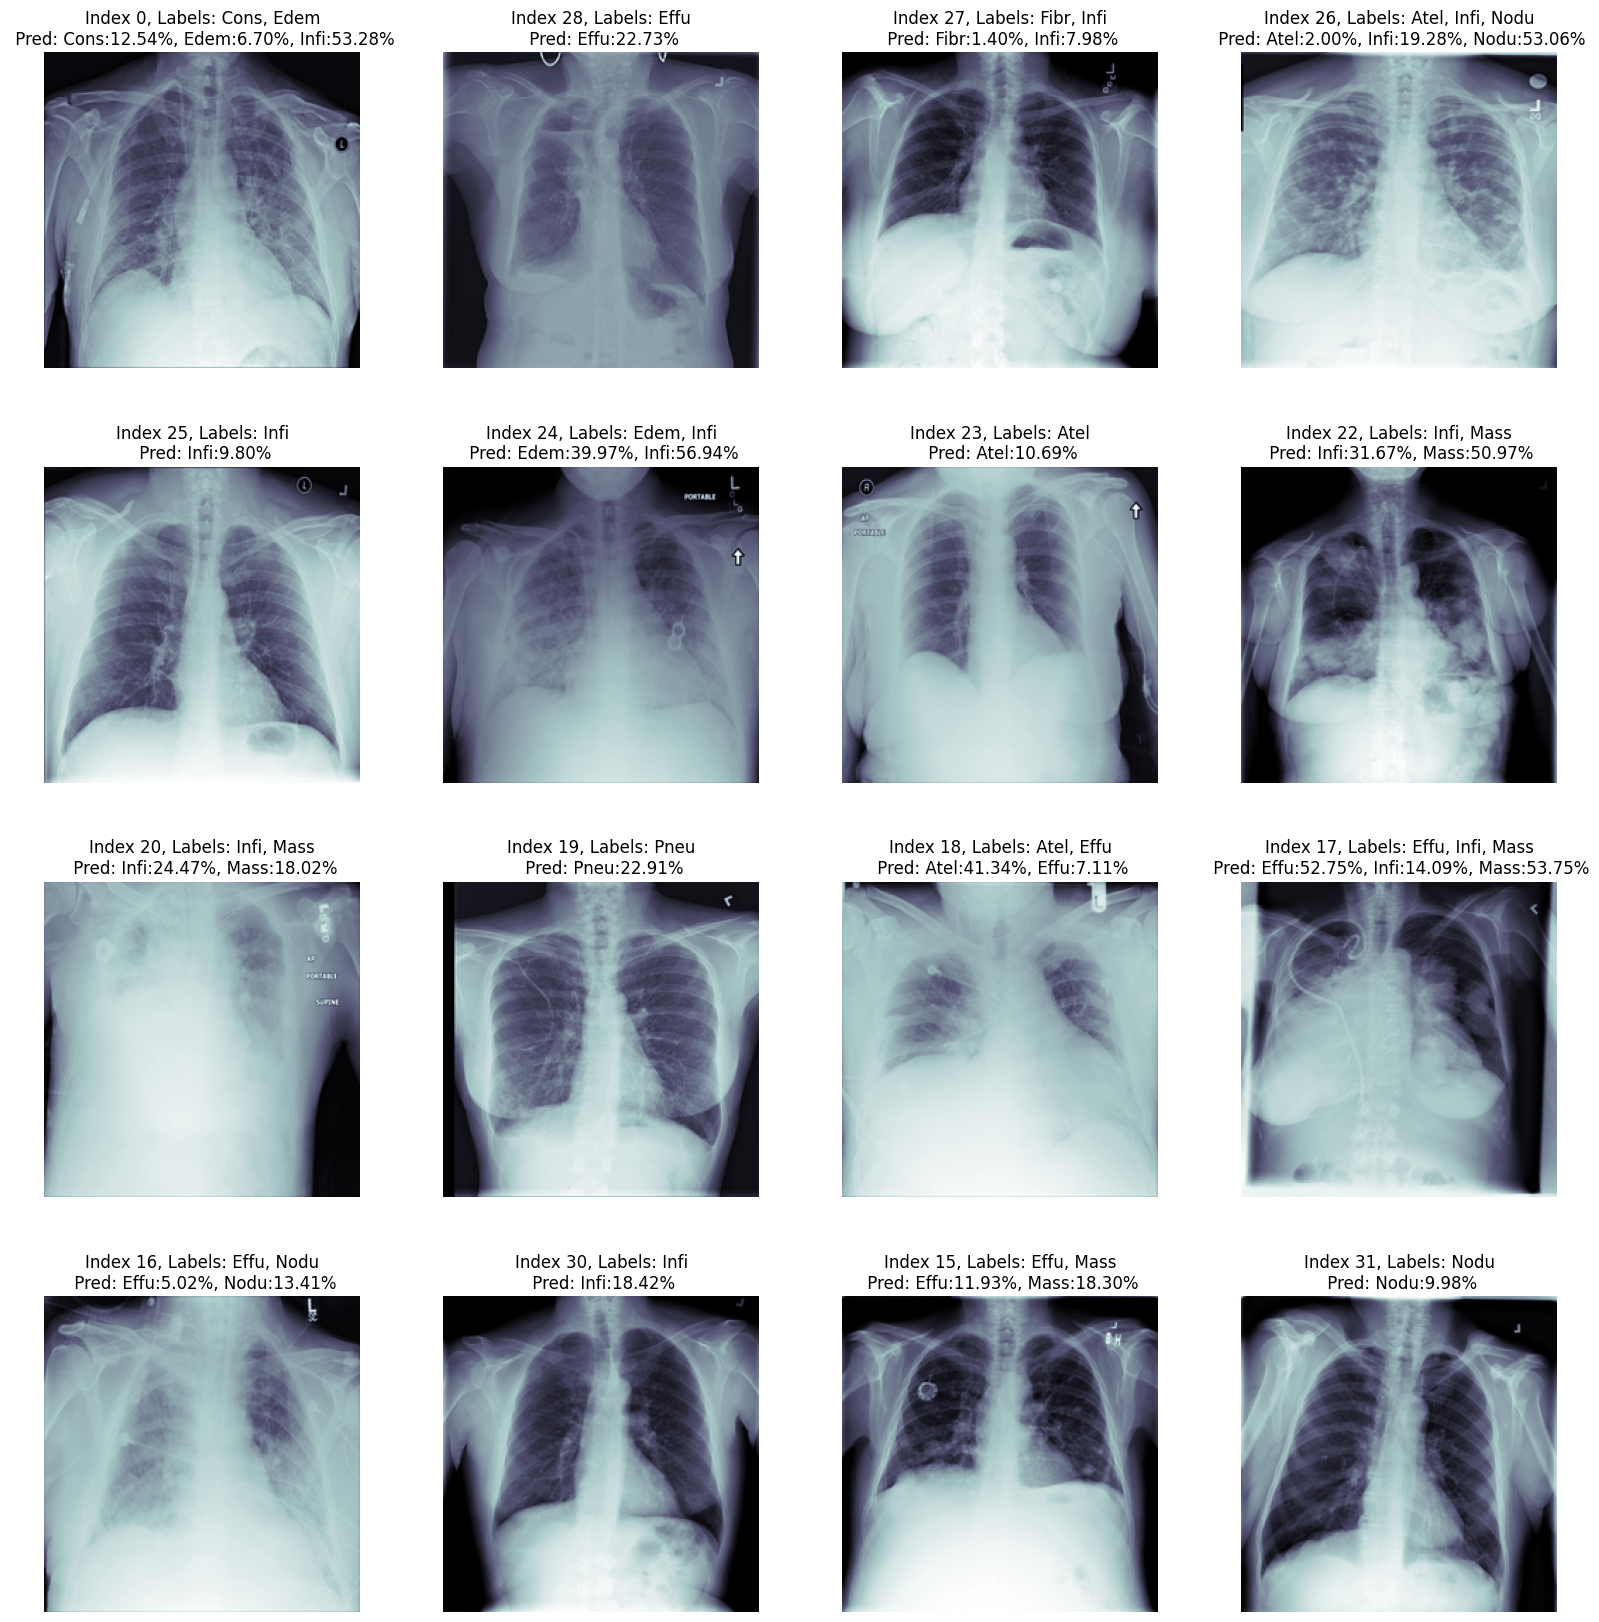

In [22]:
# Train model
epochs=25
fit_history = model.fit(
    train_gen,
    steps_per_epoch=train_gen.n//train_gen.batch_size,
    epochs=epochs,
    validation_data=valid_gen,
    validation_steps=valid_gen.n//valid_gen.batch_size,
    callbacks=callbacks,
    shuffle=False
)

# Plot training history
plt.figure(1, figsize = (15,8))

plt.subplot(222)
plt.plot(fit_history.history['loss'])
plt.plot(fit_history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'valid'])

plt.show()

# Load best weights and evaluate
model.load_weights('weights.weights.h5')

test_gen.reset()
pred_y = model.predict(test_gen, steps=len(test_gen), verbose=1)

# Trim predictions to match actual label count (handles incomplete last batch)
pred_y = pred_y[:len(test_gen.labels)]

test_gen.reset()
test_x, test_y = next(test_gen)
print(f"Vector de enfermedades: {test_y[1]}")
print(f"Vector de enfermedades producto de la predicción: {pred_y[2]}")

# Plot ROC curves
test_gen.reset()
test_x, test_y = next(test_gen)
# Space
fig, c_ax = plt.subplots(1,1, figsize = (9, 9))
for (idx, c_label) in enumerate(all_labels):
    #Points to graph
    fpr, tpr, thresholds = roc_curve(test_gen.labels[:,idx].astype(int), pred_y[:,idx])
    c_ax.plot(fpr, tpr, label = '%s (AUC:%0.2f)'  % (c_label, auc(fpr, tpr)))

#convention
c_ax.legend()

#Labels
c_ax.set_xlabel('False Positive Rate')
c_ax.set_ylabel('True Positive Rate')

# Save as a png
fig.savefig('barely_trained_net.png')

# Calculate overall ROC AUC
auc_score = roc_auc_score(test_gen.labels, pred_y)
print('ROC AUC: %f' % auc_score)

# Visualize predictions
sickest_idx = np.argsort(np.sum(test_y, 1)<1)

#Space of images
fig, m_axs = plt.subplots(4, 4, figsize = (16, 16))

# Padding
fig.tight_layout(pad=0.4, w_pad=0.5, h_pad=5.0)
counter = 0

for (idx, c_ax) in zip(sickest_idx, m_axs.flatten()):

    # Image show
    c_ax.imshow(test_x[idx, :,:,0], cmap = 'bone')

    stat_str = [n_class[:4] for n_class, n_score in zip(all_labels, test_y[idx]) if n_score>0.5]

    # Building the labels
    pred_str = [f'{n_class[:4]}:{p_score*100:.2f}%'
                for n_class, n_score, p_score
                in zip(all_labels,test_y[idx],pred_y[idx])
                if (n_score>0.5) or (p_score>0.5)]

    c_ax.set_title(f'Index {idx}, Labels: '+', '.join(stat_str)+'\n Pred: '+', '.join(pred_str))
    c_ax.axis('off')
fig.savefig('trained_img_predictions.png')

print("\nTraining and evaluation complete!")
print("Output files saved to /kaggle/working/")